## [HW6] Bartosz Ponieważ nr. albumu: 339016

## Przygotowanie danych

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# pobieranie danych

from ucimlrepo import fetch_ucirepo

chess = fetch_ucirepo(id=23)

X = chess.data.features.copy()
y = chess.data.targets.copy()

df = pd.concat([X, y], axis=1)
df.columns = df.columns.str.replace("-", "_")

In [ ]:
# mapujemy litery w kolumnach na numery aby móc policzyć odległosci 
file_map = {c: i+1 for i, c in enumerate("abcdefgh")}

for col in ["white_king_file", "white_rook_file", "black_king_file"]:
    df[col] = df[col].map(file_map)

In [ ]:
# stosuję metryki do pyt 2
dx = df["white_king_file"] - df["black_king_file"]
dy = df["white_king_rank"] - df["black_king_rank"]

df["dist_euclidean"] = np.sqrt(dx**2 + dy**2)
df["dist_manhattan"] = np.abs(dx) + np.abs(dy)
df["dist_chebyshev"] = np.maximum(np.abs(dx), np.abs(dy))

In [ ]:
# obliczamy odległość od krawędzi do pyt 3
df["black_dist_edge"] = pd.concat([
    df["black_king_file"] - 1,
    8 - df["black_king_file"],
    df["black_king_rank"] - 1,
    8 - df["black_king_rank"]
], axis=1).min(axis=1)


## Pytanie1

In [26]:
# mapowanie ilości ruchów do końca na liczby
depth_map = {
    "draw": -1,
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16
}
df["white_depth_of_win"] = (
    df["white_depth_of_win"]
    .str.strip()
    .str.lower()
    .map(depth_map)
)

mate = df[df["white_depth_of_win"] == 0]
draw = df[df["white_depth_of_win"] == -1]

In [ ]:
# tworzymy pełne szachownice do wizualizacji
full_index = pd.MultiIndex.from_product(
    [range(1,9), range(1,9)],
    names=["black_king_rank","black_king_file"]
)

mate_board = (
    mate.groupby(["black_king_rank","black_king_file"])
        .size()
        .reindex(full_index, fill_value=0)
        .unstack()
)

draw_board = (
    draw.groupby(["black_king_rank","black_king_file"])
        .size()
        .reindex(full_index, fill_value=0)
        .unstack()
)


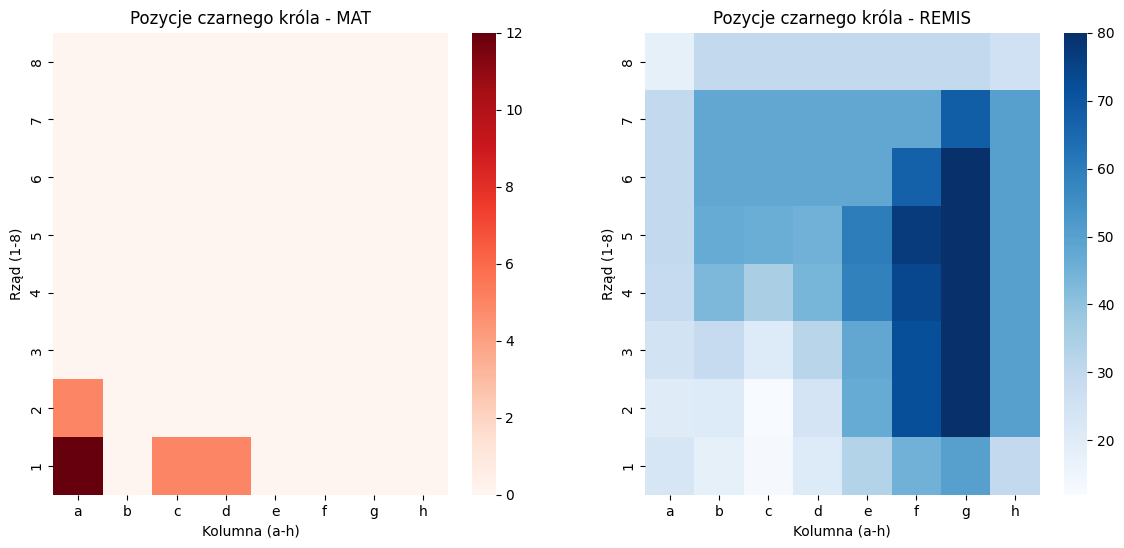

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(
    mate_board,
    cmap="Reds",
    ax=ax[0],
    xticklabels=list("abcdefgh"),
    yticklabels=range(1,9)
)
ax[0].invert_yaxis()
ax[0].set_title("Pozycje czarnego króla - MAT")

sns.heatmap(
    draw_board,
    cmap="Blues",
    ax=ax[1],
    xticklabels=list("abcdefgh"),
    yticklabels=range(1,9)
)
ax[1].invert_yaxis()
ax[1].set_title("Pozycje czarnego króla - REMIS")

ax[0].set_xlabel("Kolumna (a-h)")
ax[0].set_ylabel("Rząd (1-8)")

ax[1].set_xlabel("Kolumna (a-h)")
ax[1].set_ylabel("Rząd (1-8)")


plt.show()


W przypadku pozycji matowych czarny król znajduje się niemal wyłącznie przy krawędziach planszy, a najczęściej w jej narożnikach. Wynik ten jest zgodny z charakterem końcówki wieża–król, w której doprowadzenie do mata wymaga stopniowego ograniczania przestrzeni ruchu czarnego króla i zepchnięcia go do granicy planszy. Należy zauważyć, że ograniczony obszar występowania pozycji matowych wynika również z faktu, iż zbiór danych zawiera pozycje zredukowane względem symetrii szachownicy, co powoduje, że równoważne pozycje nie są reprezentowane wielokrotnie.

Z kolei w pozycjach remisowych czarny król najczęściej znajduje się w centralnej części planszy. Obszary te charakteryzują się większą swobodą ruchu, co utrudnia białemu graczowi skuteczne ograniczenie mobilności czarnego króla i wymuszenie mata. Rozkład pozycji remisowych jest znacznie bardziej równomierny i obejmuje większą część planszy niż w przypadku pozycji matowych.

Na podstawie przeprowadzonej analizy można stwierdzić, że pozycja czarnego króla na planszy jest silnie powiązana z wynikiem końcówki. Położenie przy krawędzi sprzyja szybkiemu zakończeniu gry matem, natomiast centralne położenie czarnego króla istotnie zwiększa prawdopodobieństwo remisu.

## Pytanie2

In [9]:
df_win = df[df["white_depth_of_win"] >= 0]


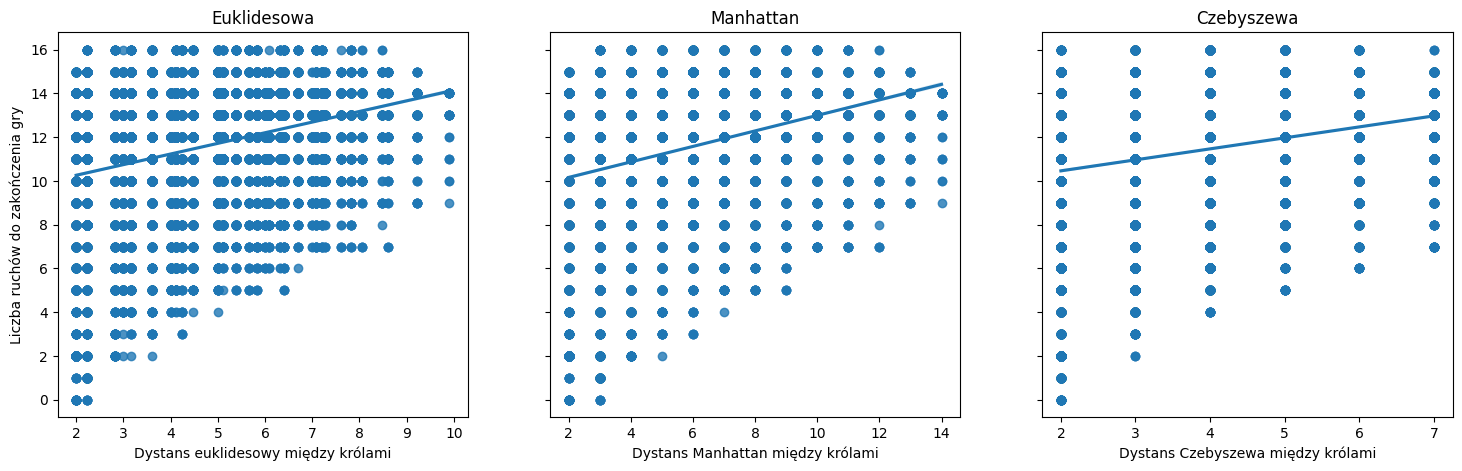

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18,5), sharey=True)

sns.regplot(x="dist_euclidean", y="white_depth_of_win", data=df_win, ax=ax[0])
ax[0].set_title("Euklidesowa")

sns.regplot(x="dist_manhattan", y="white_depth_of_win", data=df_win, ax=ax[1])
ax[1].set_title("Manhattan")

sns.regplot(x="dist_chebyshev", y="white_depth_of_win", data=df_win, ax=ax[2])
ax[2].set_title("Czebyszewa")

ax[0].set_xlabel("Dystans euklidesowy między królami")
ax[0].set_ylabel("Liczba ruchów do zakończenia gry")

ax[1].set_xlabel("Dystans Manhattan między królami")
ax[1].set_ylabel("")

ax[2].set_xlabel("Dystans Czebyszewa między królami")
ax[2].set_ylabel("")


plt.show()


In [27]:
pd.DataFrame(df_win[["white_depth_of_win","dist_euclidean","dist_manhattan","dist_chebyshev"]].corr(method='pearson')['white_depth_of_win'])

,white_depth_of_win
white_depth_of_win,1.000000
dist_euclidean,0.290681
dist_manhattan,0.296696
dist_chebyshev,0.266009


Dla sytuacji nieremisowych obliczyłem korelację rang Spearmana pomiędzy liczbą ruchów do zakończenia gry a trzema metrykami dystansu pomiędzy białym i czarnym królem. 
Otrzymałem następujące wartości korelacji:

dystans euklidesowy: p ≈ 0.29

dystans Manhattan: p ≈ 0.30

dystans Czebyszewa: p ≈ 0.27

Wszystkie trzy metryki wykazują dodatnią, lecz umiarkowaną zależność monotoniczną (korelacja spearmana) z liczbą ruchów do zakończenia gry, co oznacza, że większa odległość pomiędzy królami zazwyczaj wiąże się z dłuższym czasem potrzebnym do zakończenia partii. Różnice pomiędzy wartościami korelacji są jednak niewielkie, co wskazuje, że żadna z metryk nie stanowi jednoznacznie silnego predyktora liczby ruchów w sensie statystycznym.

Pomimo minimalnie wyższej wartości korelacji dla metryki Manhattan, metryka Czebyszewa pozostaje najbardziej adekwatna z punktu widzenia mechaniki gry w szachy, gdyż bezpośrednio odpowiada zasadom poruszania się króla i opisuje minimalną liczbę ruchów potrzebnych do zmniejszenia dystansu pomiędzy pozycjami królów. Wyniki korelacji Spearmana należy zatem traktować jako informację pomocniczą, uzupełniającą wnioski płynące z sytuacji na planszy podczas gry, bo nawet zakładając że gracze grają perfekcyjnie, niekoniecznie znaczy to że idealne strategie będą zależały od odległości.

## Pytanie 3

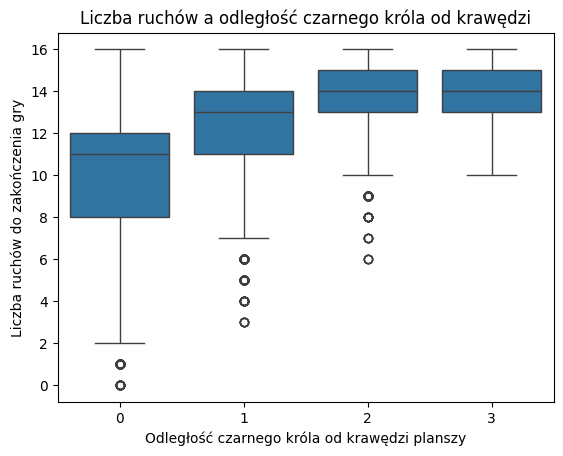

In [20]:
sns.boxplot(
    x="black_dist_edge",
    y="white_depth_of_win",
    data=df_win
)
plt.title("Liczba ruchów a odległość czarnego króla od krawędzi")
plt.xlabel("Odległość czarnego króla od krawędzi planszy")
plt.ylabel("Liczba ruchów do zakończenia gry")

plt.show()


Analiza wskazuje, że odległość czarnego króla od krawędzi planszy jest powiązana z liczbą ruchów do zakończenia gry. Pozycje, w których czarny król znajduje się bezpośrednio przy krawędzi, charakteryzują się przeciętnie mniejszą liczbą ruchów do mata, natomiast wraz ze wzrostem odległości od krawędzi rośnie typowa liczba ruchów potrzebnych do zakończenia gry

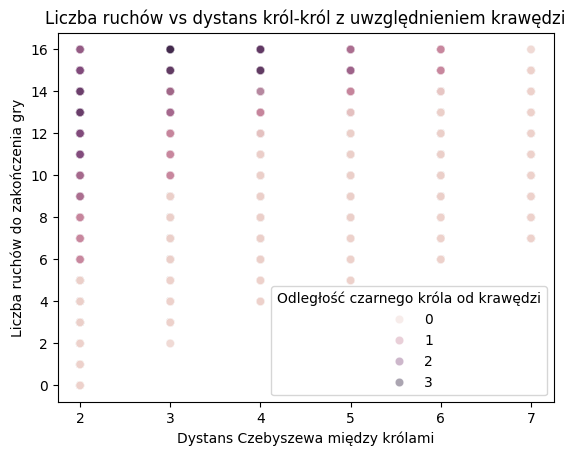

In [21]:
sns.scatterplot(
    x="dist_chebyshev",
    y="white_depth_of_win",
    hue="black_dist_edge",
    data=df_win,
    alpha=0.4
)
plt.title("Liczba ruchów vs dystans król-król z uwzględnieniem krawędzi")
plt.xlabel("Dystans Czebyszewa między królami")
plt.ylabel("Liczba ruchów do zakończenia gry")
plt.legend(title="Odległość czarnego króla od krawędzi")

plt.show()


Wykres punktowy pokazuje, że liczba ruchów do zakończenia gry rośnie wraz ze wzrostem dystansu pomiędzy białym i czarnym królem mierzonego metryką Czebyszewa która najbardziej odpowiada regułom. Jednocześnie, dla tej samej wartości dystansu król biały a król czarny, pozycje różnią się liczbą ruchów w zależności od odległości czarnego króla od krawędzi planszy. Pozycje, w których czarny król znajduje się bliżej krawędzi, charakteryzują się przeciętnie mniejszą liczbą ruchów niż pozycje, w których król znajduje się bliżej centrum planszy. Oznacza to, że informacja o położeniu czarnego króla względem krawędzi wnosi dodatkową, komplementarną informację względem samego dystansu pomiędzy królami.